<a href="https://colab.research.google.com/github/nsanghi/drl-2ed/blob/main/chapter6/6.a-dqn-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Network implementation (PyTorch).

In this notebook, we will implement DQN with **experience replay** and **target networks**.

$$
\DeclareMathOperator*{\max}{max}$$

Q Learning control is carried out by sampling step by step and updating Q values at each step. We use $\epsilon$-greedy policy to explore and generate samples. However, the policy learnt is a deterministic greedy policy with no exploration. We can carryout updates online i.e. we take a step and use `(current state, action, reward and next_state)` tuple to update.

In case of function approximation using neural network, the input to the network is the state and output is the $q(s,a)$ for all the actions in the state $s$. It is denoted as $ \hat{q}(s_t,a; w_{t}) $, where $w_{t}$ is the weigths of the neural network that we learn as part of DQN learning.

We use two networks, one target networkwirh weight $w^-_t$ to get the max $q$-value of next state denoted by $ \max\limits_a \hat {q}(s_{t+1},a; w^{-}_{t}) $ and the primary network with weights $w_{t}$ which we are updated based on back propagation of the TD error through the network.

The Update equation is given below. This is the online version:
$$ w_{t+1} \leftarrow w_t + \alpha [ R_{t+1} + \gamma . \max_{a} \hat{q}(S_{t+1},a,w^{-}_{t}) – \hat{q}(S_t,A_t,w_t)] \nabla \hat{q}(S_t,A_t,w_t)$$

Online update with neural network with millions of weights does not work well. Accordingly, We use experience replay (aka Replay Buffer).  We use a behavior policy to explore the environment and store the samples `(s, a, r, s', done)` in a buffer. The samples are generated using an exploratory behavior policy while we improve a deterministic target policy using q-values.

Therefore, we can always use older samples from behavior policy and apply them again and again. We can keep the buffer size fixed to some pre-determined size and keep deleting the older samples as we collect new ones. This process makes learning sample efficient by reusing a sample multiple times and also removing temporal dependence of the samples we would otherwise see while following a trajectory.

The update equation with batch update with minor modifications is given below. We collect samples of transitions `(current state, action, reward, next state)` in a buffer, where each sample is denoted as a tuple:

$$ (s_{i}, a_{i}, r_{i}, s'_{i}, done_{i})$$

Subscript ($i$) denotes ith sample. We take $N$ samples from experience replay selecting randomly and update the weights. Subscript ($t$) denotes the index of weight updates. If the current state is done, as denoted by `done` flag, the target is just the reward as terminal states have zero value. The final update equation is as given below:

$$w_{t+1} \leftarrow w_t + \alpha \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a'} \hat{q}(s'_{i},a'_{i};w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right] \nabla \hat{q}(s_i,a_i;w_t)$$


### Colab Installs

In [1]:
#uncomment and execute this cell to install all the the dependencies if running in Google Colab

# !apt-get update && apt-get install swig cmake ffmpeg freeglut3-dev xvfb
# !pip install box2d-py
# !pip install "stable-baselines3[extra]>=2.1"
# !pip install "huggingface_sb3>=3.0"

# !pip install git+https://github.com/DLR-RM/rl-baselines3-zoo@update/hf
# !git clone https://github.com/DLR-RM/rl-baselines3-zoo
# %cd /content/rl-baselines3-zoo/
# !pip install -r requirements.txt
# %cd ..
# !apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super -y

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [44.7 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [556 kB]
Get:9 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,131 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,398 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,009 kB

### Imports

In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve, gaussian
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from base64 import b64encode


from IPython.display import HTML

%matplotlib inline


### Environment - CartPole

We can use the setup here to run on any environment which has state as a single vector and actions are discrete. We will build it on Cart Pole. In another notebook we will run this on many other environments like Atari games and others.


In [3]:
def make_env(env_name):
    # increase time limit from 200/500 to 4000
    env = gym.make(env_name, render_mode="rgb_array", max_episode_steps=4000)
    return env

state shape:(4,)
Number of Actions:2


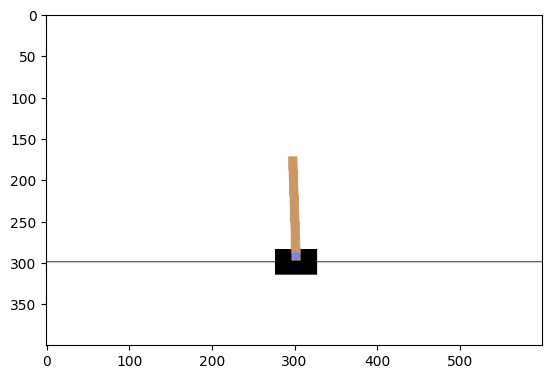

In [4]:
env_name = 'CartPole-v1'
seed=123

env = make_env(env_name)
env.reset(seed=seed)
plt.imshow(env.render())
state_shape, n_actions = env.observation_space.shape, env.action_space.n
print(f"state shape:{state_shape}\nNumber of Actions:{n_actions}")

### Building a network using pytorch

Let us build a DQN agent using a simple network. We now need to build a neural network that can map states/observations to state q-values. The observation space and action space is as given below for CartPole

    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        

The model will be a simple one with 2 hidden layers with Relu activation and final layer being logits with dimension equal to number of actions.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        state_dim = state_shape[0]
        # a simple NN with state_dim as input vector (input is state s)
        # and self.n_actions as output vector of logits of q(s, a)
        self.network = nn.Sequential()
        self.network.add_module('layer1', nn.Linear(state_dim, 256))
        self.network.add_module('relu1', nn.ReLU())
        self.network.add_module('layer2', nn.Linear(256, n_actions))
        #
        self.parameters = self.network.parameters

    def forward(self, state_t):
        # pass the state at time t through the network to get Q(s,a)
        qvalues = self.network(state_t)
        return qvalues

    def get_qvalues(self, states):
        # input is an array of states in numpy and output is Qvals as numpy array
        states = torch.tensor(np.array(states), device=device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def get_action(self, states):
        states = torch.tensor(np.array(states), device=device, dtype=torch.float32)
        qvalues = self.forward(states)
        best_actions = qvalues.argmax(axis=-1)
        return best_actions

    def sample_actions(self, qvalues):
        # sample actions from a batch of q_values using epsilon greedy policy
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

    def save(self, path):
        print("path:",path)
        torch.save(self.network.state_dict(), f"{path}.zip")


In [7]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

In [8]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    rewards = []
    for _ in range(n_games):
        s,_ = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, termiated, truncated,_ = env.step(action)
            reward += r
            if termiated:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [9]:
print(evaluate(env, agent, n_games=1))
env.close()

13.0


### Experience replay

We will use the replay buffer we saw in chapter 4 listings. Replay buffer is very important in DQN to break the correlation between samples. We use a behavior policy ($\epsilon$-greedy) to sample from the environment and store the transitions `(s,a,r,s',done)` into a buffer. These samples are used multiple times in a learning making the process sample efficient.

The interface to ReplayBuffer is:
* `exp_replay.add(state, action, reward, next_state, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns states, actions, rewards, next_states and done_flags for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

We have modified the implementation a bit to make it more efficient

In [10]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size #max number of items in buffer
        self.buffer =[] #array to hold buffer
        self.next_id = 0

    def __len__(self):
        return len(self.buffer)

    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        if len(self.buffer) < self.size:
           self.buffer.append(item)
        else:
            self.buffer[self.next_id] = item
        self.next_id = (self.next_id + 1) % self.size

    def sample(self, batch_size):
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(done_flags)

In [11]:
def play_and_record(start_state, agent, env, exp_replay, n_steps=1):

    s = start_state
    sum_rewards = 0

    # Play the game for n_steps and record transitions in buffer
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        a = agent.sample_actions(qvalues)[0]
        next_s, r, terminated, truncated, _ = env.step(a)
        sum_rewards += r
        done = terminated or truncated
        exp_replay.add(s, a, r, next_s, done)
        if done:
            s,_ = env.reset()
        else:
            s = next_s

    return sum_rewards, s

#### Target network


In [12]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

### Learning with DQN
Here we write a function similar to tabular q-learning. We will calculate average TD error per batch using the equation:

$$ L =  \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a'} \hat{q}(s'_i,a'_i;w^-_t) \right) – \hat{q}(s_i,a_i;w_t) \right]^2$$


$$ \nabla_w L =   - \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a'} \hat{q}(s'_i,a'_i;w^-_t) \right) – \hat{q}(s_i,a_i;w_t) \right] \nabla \hat{q}(s_i,a_i;w_t)$$


$\hat{q}(s',A;w^{-})$ is calculated using target network whose weights are held constant and refreshed periodically from the agent learning network.

Target is given by following:
* non terminal state: $r_i +  \gamma .  \max_{a'} \hat{q}(s'_i,a'_i;w^-_t)$
* terminal state: $ r_i $

We then carryout back propagation through the agent network to update the weights using equation below:


$$
\DeclareMathOperator*{\max}{max} w_{t+1} \leftarrow w_t - \alpha \nabla_{w}L$$

In [13]:
def compute_td_loss(agent, target_network, states, actions, rewards, next_states, done_flags,
                    gamma=0.99, device=device):

    # convert numpy array to torch tensors
    states = torch.tensor(states, device=device, dtype=torch.float)
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    done_flags = torch.tensor(done_flags.astype('float32'),device=device,dtype=torch.float)

    # get q-values for all actions in current states
    # use agent network
    predicted_qvalues = agent(states)

    # compute q-values for all actions in next states
    # use target network
    predicted_next_qvalues = target_network(next_states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]

    # compute Qmax(next_states, actions) using predicted next q-values
    next_state_values,_ = torch.max(predicted_next_qvalues, dim=1)

    # compute "target q-values"
    target_qvalues_for_actions = rewards + gamma * next_state_values * (1-done_flags)

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    return loss

### Main training Loop

We now carryout the training on DQN setup above.

In [14]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [15]:
# set a seed
seed = 132
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

#### Set up Enviroment and Policy

In [16]:
#setup env and agent and target networks
env_name = 'CartPole-v1'
env = make_env(env_name)
state_dim = env.observation_space.shape
n_actions = env.action_space.n
state,_ = env.reset(seed=seed)

agent = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

#### Populate Experience Replay

In [17]:
# let us fill experience replay with some samples using full random policy
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


#### Setup Training Paramaters

In [18]:
#setup some parameters for training
timesteps_per_epoch = 1
batch_size = 32
total_steps = 50000

#init Optimizer
opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

# set exploration epsilon
start_epsilon = 1
end_epsilon = 0.05
eps_decay_final_step = 2 * 10**4

# setup some frequency for logging and updating target network
loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

# to clip the gradients
max_grad_norm = 5000

In [19]:
mean_rw_history = []
td_loss_history = []


In [20]:
def epsilon_schedule(start_eps, end_eps, step, final_step):
    return start_eps + (end_eps-start_eps)*min(step, final_step)/final_step

def smoothen(values):
    kernel = gaussian(100, std=100)
    kernel = kernel / np.sum(kernel)
    return convolve(values, kernel, 'valid')

#### Run Training

buffer size = 10000, epsilon = 0.05000


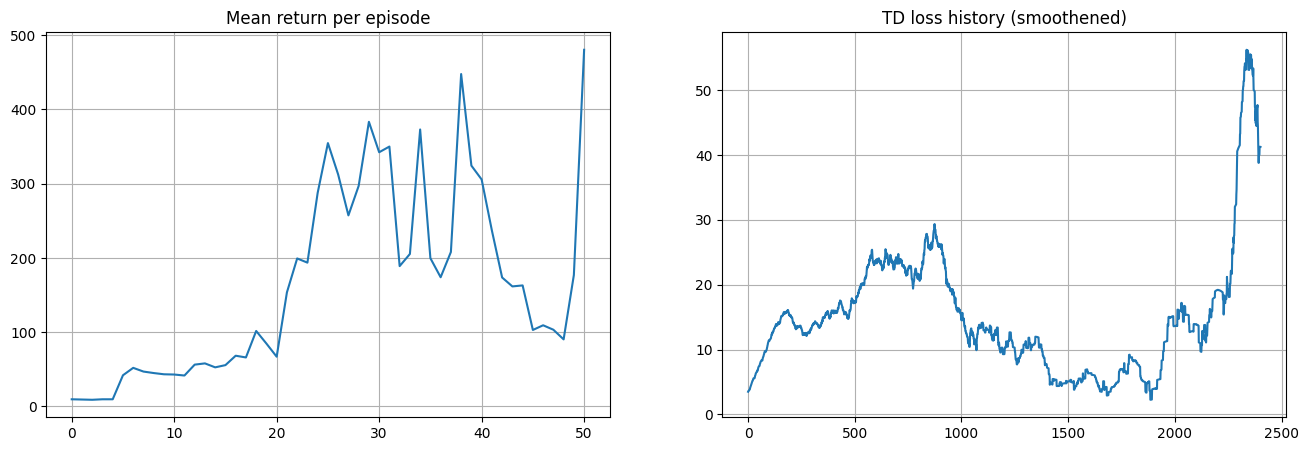

100%|██████████| 50001/50001 [03:22<00:00, 247.45it/s]


In [21]:
state,_ = env.reset()

for step in trange(total_steps + 1):

    # reduce exploration as we progress
    agent.epsilon = epsilon_schedule(start_epsilon, end_epsilon, step, eps_decay_final_step)

    # take timesteps_per_epoch and update experience replay buffer
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train by sampling batch_size of data from experience replay
    states, actions, rewards, next_states, done_flags = exp_replay.sample(batch_size)


    # loss = <compute TD loss>
    loss = compute_td_loss(agent, target_network,
                           states, actions, rewards, next_states, done_flags,
                           gamma=0.99,
                           device=device)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        # eval the agent
        mean_rw_history.append(evaluate(
            make_env(env_name), agent, n_games=3, greedy=True, t_max=1000)
        )

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 5])
        plt.subplot(1, 2, 1)
        plt.title("Mean return per episode")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(1, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(smoothen(td_loss_history))
        plt.grid()

        plt.show()

In [22]:
final_score = evaluate(
  make_env(env_name),
  agent, n_games=30, greedy=True, t_max=1000
)
print('final score:', final_score)
print('Well done')

final score: 380.9
Well done


#### Record and Play a video of trained agent

In [23]:
# Helper function to record videos
def record_video(env_id, video_folder, video_length, agent):

    vec_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    # Record the video starting at the first step
    vec_env = VecVideoRecorder(vec_env, video_folder,
                           record_video_trigger=lambda x: x == 0, video_length=video_length,
                           name_prefix=f"{type(agent).__name__}-{env_id}")

    obs = vec_env.reset()
    for _ in range(video_length + 1):
        action = agent.get_action(obs).detach().cpu().numpy()
        obs, _, _, _ = vec_env.step(action)
    # video filename
    file_path = "./"+video_folder+vec_env.video_recorder.path.split("/")[-1]
    # Save the video
    vec_env.close()
    return file_path

def play_video(file_path):
    mp4 = open(file_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
        <video width=400 controls>
              <source src="%s" type="video/mp4">
        </video>
        """ % data_url)


In [24]:
video_folder = "logs/6_a/vanilla/videos/"
video_length = 500

video_file = record_video(env_name, video_folder, video_length, agent)

play_video(video_file)

Saving video to /content/logs/6_a/vanilla/videos/DQNAgent-CartPole-v1-step-0-to-step-500.mp4
Moviepy - Building video /content/logs/6_a/vanilla/videos/DQNAgent-CartPole-v1-step-0-to-step-500.mp4.
Moviepy - Writing video /content/logs/6_a/vanilla/videos/DQNAgent-CartPole-v1-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/6_a/vanilla/videos/DQNAgent-CartPole-v1-step-0-to-step-500.mp4


### Train DQN using SB3

You can package the video generated to huggingface manually and share. However to share the trained model parameters and replay video, it involves more work which requires you to save the model weight and upload.
Instead we will retrain the model using stablebaseline3 (sb3) and upload the model to hugging face using utilities provided in sb3.

#### Create DQN Agent
We will create a DQN agent with same architecture as before i.e. with two Fully COnnected Linear layers of size 256

In [25]:
# create the DQN agent
from stable_baselines3 import DQN

#define a policy matching ours
#define the activation function and the network layers size
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=[256, 256])


env = gym.make(env_name, render_mode="rgb_array")
model = DQN("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


#### Print the Policy Network

In [26]:
model.policy

DQNPolicy(
  (q_net): QNetwork(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (q_net): Sequential(
      (0): Linear(in_features=4, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (q_net_target): QNetwork(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (q_net): Sequential(
      (0): Linear(in_features=4, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
)

#### Train the model

In [27]:
model.learn(total_timesteps=1e5, log_interval=500, progress_bar=True)
model.save("logs/6_a/sb3/dqn_cartpole")

Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.9     |
|    ep_rew_mean      | 20.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 500      |
|    fps              | 4075     |
|    time_elapsed     | 2        |
|    total_timesteps  | 11201    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.8     |
|    ep_rew_mean      | 24.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1000     |
|    fps              | 2988     |
|    time_elapsed     | 7        |
|    total_timesteps  | 22442    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.4     |
|    ep_rew_mean      | 21.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:283: UserWarning: Path 'logs/6_a/sb3' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


#### Record Video for sb3

In [28]:
# Helper function to record videos for sb3 model
def record_video_sb3(env_id, video_folder, video_length, model):

    vec_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    # Record the video starting at the first step
    vec_env = VecVideoRecorder(vec_env, video_folder,
                           record_video_trigger=lambda x: x == 0, video_length=video_length,
                           name_prefix=f"{type(agent).__name__}-{env_id}")

    obs = vec_env.reset()
    for _ in range(video_length + 1):
        action, _state = model.predict(obs)
        obs, _, _, _ = vec_env.step(action)
    # video filename
    file_path = "./"+video_folder+vec_env.video_recorder.path.split("/")[-1]
    # Save the video
    vec_env.close()
    return file_path


video_folder = "logs/6_a/sb3/videos/"
video_length = 500

video_file_sb3 = record_video_sb3(env_name, video_folder, video_length, model)
play_video(video_file_sb3)

Saving video to /content/logs/6_a/sb3/videos/DQNAgent-CartPole-v1-step-0-to-step-500.mp4
Moviepy - Building video /content/logs/6_a/sb3/videos/DQNAgent-CartPole-v1-step-0-to-step-500.mp4.
Moviepy - Writing video /content/logs/6_a/sb3/videos/DQNAgent-CartPole-v1-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/6_a/sb3/videos/DQNAgent-CartPole-v1-step-0-to-step-500.mp4


#### Share the agent using HuggingFace

Get your Hugging Face token ready as we will need in next code cell to be able to login into your hugging face account

**Enter your Token**

In [29]:
from huggingface_sb3 import load_from_hub, package_to_hub, push_to_hub
from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.

notebook_login()
!git config --global credential.helper store

In [30]:
eval_env = DummyVecEnv([lambda: gym.make(env_name, render_mode="rgb_array")])
obs = eval_env.reset()

# method save, evaluate, generate a model card and record a replay video of your agent before pushing the repo to the hub

# Please note repo_id is of the form <huggingface_id>/<name of repo>
# you will need to change this to "<your_huggingface_id>/dqn-cart-pole-v1"

package_to_hub(model=model, # Our trained model
               model_name= "DQN-" + env_name, # The name of our trained model
               model_architecture="DQN", # The model architecture we used: in our case PPO
               env_id=env_name, # Name of the environment
               eval_env=eval_env, # Evaluation Environment
               repo_id="nsanghi/dqn-cart-pole-sb3", # id of the model repository from the Hugging Face Hub (repo_id = {organization}/{repo_name}
               commit_message="Push to Hub")

ℹ This function will save, evaluate, generate a video of your agent,
create a model card and push everything to the hub. It might take up to 1min.
This is a work in progress: if you encounter a bug, please open an issue.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Saving video to /tmp/tmpfna0ih7r/-step-0-to-step-1000.mp4
Moviepy - Building video /tmp/tmpfna0ih7r/-step-0-to-step-1000.mp4.
Moviepy - Writing video /tmp/tmpfna0ih7r/-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpfna0ih7r/-step-0-to-step-1000.mp4
ℹ Pushing repo nsanghi/dqn-cart-pole-sb3 to the Hugging Face Hub


policy.optimizer.pth:   0%|          | 0.00/546k [00:00<?, ?B/s]

policy.pth:   0%|          | 0.00/545k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

DQN-CartPole-v1.zip:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

ℹ Your model is pushed to the Hub. You can view your model here:
https://huggingface.co/nsanghi/dqn-cart-pole-sb3/tree/main/


'https://huggingface.co/nsanghi/dqn-cart-pole-sb3/tree/main/'

### Train using RL_Zoo3
We will also be using Weights and Biases to records the run and other experiment details. For thsis we need to login using the wandb api key

In [31]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

#### Train agent

In [32]:
!python -m rl_zoo3.train --algo dqn --env CartPole-v1 --save-freq 10000 \
--eval-freq 10000 --eval-episodes 10 --log-interval 400 --progress \
--track --wandb-project-name dqn-cartpole -f logs/6_a/rlzoo3/

2023-10-26 12:14:31.021821: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-26 12:14:31.021899: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-26 12:14:31.021954: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 12:14:32.810042: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
========== CartPole-v1 ==========
Seed: 3520579075
wandb: Currently logged in as: nsanghi. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.12
wandb: Run data is saved locally in /content/wandb/run-

#### Evaluate Trained agent
Print the performance of the trained agent

In [33]:
!python -m rl_zoo3.enjoy --algo dqn --env CartPole-v1 --no-render --n-timesteps 5000 --folder logs/6_a/rlzoo3

2023-10-26 12:16:50.743366: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-26 12:16:50.743423: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-26 12:16:50.743458: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 12:16:51.928981: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading latest experiment, id=1
Loading logs/6_a/rlzoo3/dqn/CartPole-v1_1/CartPole-v1.zip
Episode Reward: 500.00
Episode Length 500
Episode Reward: 500.00
Episode Length 500
Episode Reward: 500.00
Episode Length 500
Episode Reward: 500.00

#### Record a video
Let us now record and play a video of a trained agent. We use rl_zoo for generating the video and then use our custom function to play the video

In [34]:
!python -m rl_zoo3.record_video --algo dqn --env CartPole-v1 --exp-id 0 -f logs/6_a/rlzoo3/ -n 1000

2023-10-26 12:17:08.550467: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-26 12:17:08.550527: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-26 12:17:08.550559: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 12:17:09.760262: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading latest experiment, id=1
Loading logs/6_a/rlzoo3/dqn/CartPole-v1_1/CartPole-v1.zip
Loading logs/6_a/rlzoo3/dqn/CartPole-v1_1/CartPole-v1.zip
error: XDG_RUNTIME_DIR not set in the environment.
Saving video to /content/logs/6_a/rlzoo

In [35]:
video_file_rlzoo = "logs/6_a/rlzoo3/dqn/CartPole-v1_1/videos/final-model-dqn-CartPole-v1-step-0-to-step-1000.mp4"
play_video(video_file_rlzoo)

#### Share on HuggingFace
This time we will use the `pust_to_hub` function from `rl_zoo3` to push the trained agent to Huggingface Hub. When you run, the `organization` name has to point to your own huggingface user name.  

In [36]:
!python -m rl_zoo3.push_to_hub --algo dqn --env CartPole-v1 --exp-id 0 \
--folder logs/6_a/rlzoo3 --n-timesteps 1000 --verbose 1 --load-best  \
--organization nsanghi --repo-name dqn-cart-pole-rlzoo -m "Push to Hub"

2023-10-26 12:17:56.942975: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-26 12:17:56.943033: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-26 12:17:56.943067: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 12:17:58.121752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading latest experiment, id=1
Loading logs/6_a/rlzoo3/dqn/CartPole-v1_1/best_model.zip
Uploading to nsanghi/dqn-cart-pole-rlzoo, make sure to have the rights
ℹ This function will save, evaluate, generate a video of your agent,
create a 

#### HyperParameter Optimization
In case you want to further optimize the hyperparameters of the model, you can run something like this. It uses the values as defined in [`hyperparams_opt.py`](https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/rl_zoo3/hyperparams_opt.py#L386) to carry out search over a wide range of hyperparameters using [Optuna](https://optuna.org/). You can follow these links and rl_zoo3 documentation for more details.

Do not run the below cell unless you have a GPU and even then it will take substantial time. with `max-totl-trials=25` it takes about an hour on a cpu. This number needs to be increased to 100-300 for a decent search of the parameter space.

In [ ]:
# !python -m rl_zoo3.train --algo dqn --env CartPole-v1 --save-freq 10000 \
# --eval-episodes 10 --log-interval 100 --progress --track \
# --wandb-project-name dqn-cartpole \
# --optimization-log-path logs/optimization/ --log-folder logs --optimize-hyperparameters --n-jobs 2 \
# --study-name dqn-test --max-total-trials 25

**For doing a parsing of optimization study**

Please refer to RL Zoo3 documentation for further details.

In [ ]:
# !python -m rl_z003.plots.parse_study -i ./logs/dqn/report_CartPole-v1_500-trials-50000-tpe-median_1698290229.pkl --print-n-best-trials 10 \
# --save-n-best-hyperparameters 10 --folder ./logs/dqn/6.a/best-params/

#### Plotting the charts
We need to have multiple training run outputs. So we run it once more

In [37]:
!python -m rl_zoo3.train --algo dqn --env CartPole-v1 --save-freq 10000 \
--eval-freq 10000 --eval-episodes 10 --log-interval 400 --progress \
--track --wandb-project-name dqn-cartpole -f logs/6_a/rlzoo3/

2023-10-26 12:18:42.798513: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-26 12:18:42.798567: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-26 12:18:42.798599: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 12:18:44.002854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
========== CartPole-v1 ==========
Seed: 776939375
wandb: Currently logged in as: nsanghi. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.12
wandb: Run data is saved locally in /content/wandb/run-2

#### Prepare the results File
Here we have done only two runs and therefore the results will not be anything great. In a real use case you will have multiple runs ans then you will plot the performance charts. You can refer to the code file and documentation for more details

In [38]:
!python -m rl_zoo3.plots.all_plots --algo dqn --env CartPole-v1 \
-f logs/6_a/rlzoo3/ -o logs/6_a/rlzoo3/dqn_results

2023-10-26 12:20:58.409490: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-26 12:20:58.409553: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-26 12:20:58.409590: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 12:20:59.615007: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'rl_zoo3.plots.all_plots' found in sys.modules after import of package 'rl_zoo3.plots', but prior to execution of 'rl_zoo3.plots.all_plots'; this may result in unpredictable behaviour
  wa

#### Plot the results in a svg file
Open the svg file after you run the command below. Path of the svg file is given in the command

In [39]:
!python -m rl_zoo3.plots.plot_from_file -i logs/6_a/rlzoo3/dqn_results.pkl \
-latex -l DQN --output logs/6_a/rlzoo3/dqn_test_plot.svg

2023-10-26 12:21:12.474241: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-26 12:21:12.474301: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-26 12:21:12.474337: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 12:21:13.735177: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'rl_zoo3.plots.plot_from_file' found in sys.modules after import of package 'rl_zoo3.plots', but prior to execution of 'rl_zoo3.plots.plot_from_file'; this may result in unpredictable beha

#### Rliable plot
When you rin this you will see error like:
```
CartPole-v1 not found for normalizing scores, you should update `env_key_to_env_id`
  warnings.warn(f"{env} not found for normalizing scores, you should update `env_key_to_env_id`")
```
To fix this you can refer to the instructions towards the end of the page at [this link](https://rl-baselines3-zoo.readthedocs.io/en/master/guide/plot.html)

The provided in its current form is meant for a few PyBullet environments  

In [ ]:
!python -m rl_zoo3.plots.plot_from_file -i logs/6_a/rlzoo3/dqn_results.pkl \
--rliable --versus --iqm --boxplot \
-latex -l DQN --output logs/6_a/rlzoo3/dqn_test1_plot.svg

2023-10-26 15:19:42.659313: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-26 15:19:42.695186: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-26 15:19:42.695270: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-26 15:19:42.695294: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 15:19:42.701812: I tensorflow/core/platform/cpu_feature_g

### Summary

In this notebook we saw how to train a DQN agent with experience replay and target networks. We can improve this agent with many tricks. As we go along, we will be implementing many of these variants.